In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
%qtconsole

# Functions

## Resampling Techniques

In [2]:
def resampling_method(given_idx_list, method_type, block_size, parameters):
    #####################################################
    ##### This function implements different types of bootstrap, assigned as a str in the method_type:
    # given_idx_list => an index list, usually a np.arange or another similar type (avoid using simply range())
    ### 1 - simple -> vanilla bootstrap (no parameters is necessary)
    ### 2 - block -> block bootstrap with fixed block size (BlockSize in parameters)
    ### 3 - circular -> block bootstrap with fixed block size and pluging the time series end and start indices
    ### 4 - stationary -> similar as circular but with random block size (Geom(block_size))
    ### 5 - conditional -> TBI
    ##### we assume that the number of bootstrap samples is equivalent to the len(idx_list)
    ##### return: the resampled indices (rs_idx_list) and the non-listed indices (out_idx_list)
    
    # packages
    import numpy as np
    
    # simple pre-processing
    idx_list = range(len(given_idx_list))
     
    # vanilla bootstrap
    if method_type == "simple":
        # resampled indices
        rs_idx_list = np.random.choice(idx_list, size=len(idx_list), replace=True)
        
        # indices not considered
        out_idx_list = np.delete(idx_list, np.unique(rs_idx_list))
    
    # block bootstrap
    elif method_type == "block":
        blocks = []
        # form blocks
        for i in range(len(idx_list)-block_size+1): blocks.append(idx_list[i:(i+block_size)])
        
        # resample blocks
        block_idx_list = np.random.choice(len(blocks), size=np.ceil(len(idx_list)/block_size), replace=True)
        
        # concatenate indices
        rs_idx_list = blocks[block_idx_list[0]]
        for i in range(1, len(block_idx_list)): rs_idx_list += blocks[block_idx_list[i]]
        
        # indices not considered
        rs_idx_list = np.array(rs_idx_list[:len(idx_list)])
        out_idx_list = np.delete(idx_list, np.unique(rs_idx_list))
        
    # circular (stationary) bootstrap
    elif method_type == "circular":        
        # get starting indices
        circ_idx_list = np.random.choice(idx_list, size=np.ceil(len(idx_list)/block_size), replace=True)
        
        # get id's in the block and concatenate them
        rs_idx_list = []
        for i in range(len(circ_idx_list)): 
            # not going to surpass the last index available
            if (idx_list[circ_idx_list[i]]+block_size) < len(idx_list):
                rs_idx_list += idx_list[circ_idx_list[i]:circ_idx_list[i]+block_size]
            else: # in case it surpass
                rem = (idx_list[circ_idx_list[i]]+block_size) - len(idx_list)
                rs_idx_list += idx_list[circ_idx_list[i]:]
                rs_idx_list += idx_list[:rem]
        
        # indices not considered
        rs_idx_list = np.array(rs_idx_list[:len(idx_list)])
        out_idx_list = np.delete(idx_list, np.unique(rs_idx_list))

    # stationary (random) bootstrap
    elif method_type == "stationary":        
        # get starting indices
        circ_idx_list = np.random.choice(idx_list, size=5.*np.ceil(len(idx_list)/block_size), replace=True)
        
        # get id's in the block and concatenate them
        rs_idx_list = []
        for i in range(len(circ_idx_list)): 
            # get random block size
            random_size = np.random.geometric(1./block_size)
            # not going to surpass the last index available
            if (idx_list[circ_idx_list[i]]+random_size) < len(idx_list):
                rs_idx_list += idx_list[circ_idx_list[i]:circ_idx_list[i]+random_size]
            else: # in case it surpass
                rem = (idx_list[circ_idx_list[i]]+random_size) - len(idx_list)
                rs_idx_list += idx_list[circ_idx_list[i]:]
                rs_idx_list += idx_list[:rem]
        
        # indices not considered
        rs_idx_list = np.array(rs_idx_list[:len(idx_list)])
        out_idx_list = np.delete(idx_list, np.unique(rs_idx_list))
        
    # conditional bootstrap
    ### tbi
    
    # return
    return given_idx_list[rs_idx_list], given_idx_list[out_idx_list]

## Performance Metrics

In [199]:
def perf_metrics(asset_returns, metric_type, benchmark=None):
    #########################################
    ##### this function computes some performance metric, using a certain metric_type:
    ### metric_type == "AvgRet"
    ### metric_type == "SharpeRatio"
    ### metric_type == "Alpha"
    ##### the benchmark is useful only to compute the CAPM alpha
    #########################################
    
    # AvgRet -- the constant was ignored
    if metric_type == "AvgReturn":
        performance = asset_returns.mean()*252.0

    # Volatility -- the constant was ignored 
    if metric_type == "Vol":
        performance = asset_returns.std()*(252**(1./2))
        
    # SharpeRatio -- considering daily returns
    elif metric_type == "SharpeRatio":
        performance = (asset_returns.mean()*252.0)/(asset_returns.std()*(252**(1./2)))
    
    # Var 99%
    elif metric_type == "Var":
        performance = (asset_returns.quantile(.99))
    
    # Alpha
    elif metric_type == "Alpha":
        all_returns = pd.concat([asset_returns, benchmark], axis=1)
        performance = asset_returns.mean().sub(all_returns.corr().iloc[-1].mul(asset_returns.std()/benchmark.std())).mul(benchmark.mean())
        #performance = ("Not Implemented Yet")
    
    # return
    return performance

#  DGS

In [4]:
def vanilla_returns(n_asset, length):
        mean = np.repeat(0, n_asset)
        cov = np.identity(n_asset)
        rets = np.random.multivariate_normal(mean, cov, length)/100
        return pd.DataFrame(rets, columns=map(chr, range(65, 65+n_asset)))

# White BRC (2000)

In [204]:
def white_brc(assets_returns, benchmark, parameters):
    ####################################################
    ##### this function implements the white reality check (2000)
    ### assets_returns -- matrix or data frame with the assets returns over time
    ### benchmark -- a benchmark used to compare every strategy (can be set to 0, just to check if it provides a positive return)
    ### parameters -- the parameters are the following
    # UpperType -- bootstrap method used to resample the assets returns (first resampling, in case of two-stage or double bootstrap)
    # UpperBlockSize -- in the case of some block bootstrap, define the block size used to sample the ts
    # PerfMetric -- which metric is being used to compare asset returns and the benchmark (Asset Return, Sharpe Ratio and Alpha)
    # Vol-Scaling -- value to vol-scale different instruments before taking any differences
    ####################################################
    
    ##### packages
    import pandas as pd
    import numpy as np
    
    ##### vol-scaling
    assets_returns = assets_returns.div(assets_returns.std()).mul(parameters["Vol-Scaling"]/np.sqrt(252))
    benchmark = benchmark.div(benchmark.std()).mul(parameters["Vol-Scaling"]/np.sqrt(252))
    
    ##### difference between asset returns and benchmark
    dif_returns = assets_returns.pipe(lambda x: np.log(1+x)).subtract(np.log(1+benchmark), axis=0)
    if parameters["BetterOff"]=="Min":
        dif_returns = dif_returns.mul(-1)

    ##### performance measure for Vhat
    perf_assets = perf_metrics(dif_returns, parameters["PerfMetric"])
    
    ### check if it's going to be stundentized or not (higher power, due to variance controlling)
    if parameters["Studentized"] == False:
        ##### find Vhat -- max_S(avg_dif)
        Vhat = max(np.sqrt(len(dif_returns)) * perf_assets)

        ##### bootstrap
        ### for all samples
        Vb = []
        for i in range(parameters["UpperSize"]):
            ### bootstrap samples
            idx_list = np.arange(len(assets_returns))
            boot_idx = resampling_method(idx_list, parameters["UpperType"], parameters["UpperBlockSize"], parameters)[0]
            ### performance stats
            perf_boot = perf_metrics(dif_returns.ix[boot_idx, :], parameters["PerfMetric"])
            boot_stat = max(np.sqrt(len(dif_returns.ix[boot_idx, :])) * (perf_boot - perf_assets)) #- perf_assets))
            Vb.append(boot_stat)

        ##### p-value reality check
        prc = np.mean(Vb > Vhat) # perhaps in absolute terms?
    
    else: # in case it's studentized
        ##### double bootstrap
        idx_list = np.arange(len(assets_returns))
        stats_stderr = pd.DataFrame(index=range(parameters["UpperSize"]), 
                          columns=assets_returns.columns.values) # dataframe that stores upper boot test stat info
        stderrboot = pd.DataFrame(index=range(parameters["UpperSize"]), 
                            columns=assets_returns.columns.values) # dataframe that stores lower boot test stat info
        ### for all samples
        for i in range(parameters["UpperSize"]):
            ### bootstrap samples
            boot_idx = resampling_method(idx_list, parameters["UpperType"], parameters["UpperBlockSize"], parameters)[0]
            ### performance stats
            stats_stderr.ix[i, assets_returns.columns.values] = perf_metrics(dif_returns.ix[boot_idx, :], 
                                                                             parameters["PerfMetric"])
            
            ### nested bootstrap
            Vbb = pd.DataFrame(index=range(parameters["LowerSize"]), columns=assets_returns.columns.values) # dataframe for double boot
            for j in range(parameters["LowerSize"]):
                # double bootstrap samples
                nested_idx = resampling_method(boot_idx, parameters["LowerType"], parameters["LowerBlockSize"], parameters)[0]
                # performance stats
                Vbb.ix[j, assets_returns.columns.values] = perf_metrics(dif_returns.ix[nested_idx, :], parameters["PerfMetric"])
            
            ### store results
            stderrboot.ix[i, assets_returns.columns.values] = Vbb.std(axis=0)
            
        ##### find Vhat -- max_S(avg_dif) based on studentized stat
        z_perf = perf_assets/stats_stderr.std()
        Vhat = max(z_perf)
        
        ##### compute Vb studentized
        Vb = []
        for i in range(parameters["UpperSize"]):
            zboot_perf = stats_stderr.ix[i, :]/stderrboot.ix[i, :]
            Vb.append( max(zboot_perf - z_perf) ) #- perf_assets))
        
        ##### p-value reality check
        prc = np.mean(Vb > Vhat) # perhaps in absolute terms?
    
    # return
    return {"White p-value": prc, "White observed test stats": Vhat, "White bootstrapped test stats": Vb}

# Romano and Wolf (2005)

In [205]:
def romanowolf_brc(assets_returns, benchmark, parameters):
    ####################################################
    ##### this function implements the romano-wolf (2005) version of bootstrap reality check (originally developed by White)
    ### assets_returns -- matrix or data frame with the assets returns over time
    ### benchmark -- a benchmark used to compare every strategy (can be set to 0, just to check if it provides a positive return)
    ### parameters -- the parameters are the following
    # UpperType -- bootstrap method used to resample the assets returns (first resampling, in case of two-stage or double bootstrap)
    # UpperBlockSize -- in the case of some block bootstrap, define the block size used to sample the ts
    # PerfMetric -- which metric is being used to compare asset returns and the benchmark (Asset Return, Sharpe Ratio and Alpha)
    # Studentized -- divide the difference stats by the standard deviation of the difference (sometimes it requires a double bootstrap)
    # LowerType -- bootstrap method used in the second stage, used to estimate the standard deviation of the test stats
    # LowerBlockSize -- the block size used for the second stage block bootstrap
    # SignificanceLevel -- the level used to controle de false positive rate (rejecting when it was not false)
    # Vol-Scaling -- value to vol-scale different instruments before taking any differences
    ####################################################
    
    ##### packages
    import pandas as pd
    import numpy as np
    
    
    ##### vol-scaling
    assets_returns = assets_returns.div(assets_returns.std()).mul(parameters["Vol-Scaling"]/np.sqrt(252))
    benchmark = benchmark.div(benchmark.std()).mul(parameters["Vol-Scaling"]/np.sqrt(252))
    
    ##### difference between asset returns and benchmark
    dif_returns = assets_returns.pipe(lambda x: np.log(1+x)).subtract(np.log(1+benchmark), axis=0)
    if parameters["BetterOff"]=="Min":
        dif_returns = dif_returns.mul(-1)

    ##### performance measure for Vhat
    perf_assets = np.array(perf_metrics(dif_returns, parameters["PerfMetric"]))
    
    ### check if it's going to be stundentized or not (higher power, due to variance controlling)
    if parameters["Studentized"] == False:
        ##### find Vhat -- max_S(avg_dif)
        Vhat = max(np.sqrt(len(dif_returns)) * perf_assets)

        ##### main loop
        # pre-allocation
        test_strat = assets_returns.columns.values
        rejected_strat, tstat_strat, crit_values = ([], [], [])
        out_k = np.array([True])
        k=1
        
        ### while some strategy have not been rejected
        while (len(test_strat) > 0 and sum(out_k) > 0):
            
            Vb_k = []
            for i in range(parameters["UpperSize"]):
                ### bootstrap samples
                idx_list = np.arange(len(assets_returns))
                boot_idx = resampling_method(idx_list, parameters["UpperType"], parameters["UpperBlockSize"], parameters)[0]
                ### performance stats
                perf_boot = perf_metrics(dif_returns.ix[boot_idx, test_strat], parameters["PerfMetric"])
                boot_stat = max(np.sqrt(len(dif_returns.ix[boot_idx, test_strat])) * (perf_boot - perf_assets)) #- perf_assets))
                Vb_k.append(boot_stat)
        
            if k==1: # first iteration, treated as White Reality Check
                Vb = Vb_k # first bootstrap samples
                prc = np.mean(Vb > Vhat) # p-value reality check
            
            ### find critical values and outperforming strategies
            c_k = np.percentile(Vb_k, ( 1.0-(parameters['SignificanceLevel']/(1.0)) )*100.0) #k)) )*100)
            out_k = (np.sqrt(len(dif_returns)) * perf_assets) > c_k
            
            ### organize outputs
            rejected_strat += [test_strat[out_k]]
            tstat_strat += [np.sqrt(len(dif_returns)) * perf_assets[out_k]]
            crit_values += [c_k]
            
            ### remove strategies
            test_strat = np.delete(test_strat, np.where(out_k == True))
            perf_assets = np.delete(perf_assets, np.where(out_k == True))
            
            # next iteration
            k+=1
        
        ### save non significant results in the last echelon
        rejected_strat += [test_strat]
        tstat_strat += [np.sqrt(len(dif_returns)) * np.array(perf_assets)]
    
    else: # in case it's studentized
        
        ##### double bootstrap
        # pre-allocation
        idx_list = np.arange(len(assets_returns))
        test_strat = assets_returns.columns.values
        rejected_strat, tstat_strat, crit_values = ([], [], [])
        out_k = np.array([True])
        k=1
        
        ### while some strategy have not been rejected
        while (len(test_strat) > 0 and sum(out_k) > 0):
            
            # pre-allocation [2]
            stats_stderr = pd.DataFrame(index=range(parameters["UpperSize"]), 
                          columns=test_strat) # dataframe that stores upper boot test stat info
            stderrboot = pd.DataFrame(index=range(parameters["UpperSize"]), 
                            columns=test_strat) # dataframe that stores lower boot test stat info
            
            ### for all samples
            for i in range(parameters["UpperSize"]):
                ### bootstrap samples
                boot_idx = resampling_method(idx_list, parameters["UpperType"], parameters["UpperBlockSize"], parameters)[0]
                ### performance stats
                stats_stderr.ix[i, test_strat] = perf_metrics(dif_returns.ix[boot_idx, test_strat], parameters["PerfMetric"])
                ### nested bootstrap
                Vbb = pd.DataFrame(index=range(parameters["LowerSize"]), columns=test_strat) # dataframe for double boot
                for j in range(parameters["LowerSize"]):
                    # double bootstrap samples
                    nested_idx = resampling_method(boot_idx, parameters["LowerType"], 
                                                   parameters["LowerBlockSize"], parameters)[0]
                    # performance stats
                    Vbb.ix[j, test_strat] = perf_metrics(dif_returns.ix[nested_idx, test_strat], parameters["PerfMetric"])
                
                ### store results
                stderrboot.ix[i, test_strat] = Vbb.std(axis=0)
            
            ##### studentized stats
            z_perf = np.array(perf_assets/stats_stderr.std())
            Vb_k = []
            for i in range(parameters["UpperSize"]):
                zboot_perf = stats_stderr.ix[i, :]/stderrboot.ix[i, :]
                Vb_k.append( max(zboot_perf - z_perf) ) #- perf_assets))
                
            if k==1: # first iteration, treated as White Reality Check
                Vb = Vb_k # first bootstrap samples
                Vhat = max(z_perf) # max of studentized stats
                prc = np.mean(Vb > Vhat) # p-value reality check
                
            ### find critical values and outperforming strategies
            c_k = np.percentile(Vb_k, ( 1.0-(parameters['SignificanceLevel']/(1.0)) )*100.0) #k)) )*100)
            out_k = z_perf > c_k
            
            ### organize outputs
            rejected_strat += [test_strat[out_k]]
            tstat_strat += [z_perf[out_k]]
            crit_values += [c_k]
            
            ### remove strategies
            test_strat = np.delete(test_strat, np.where(out_k == True))
            perf_assets = np.delete(perf_assets, np.where(out_k == True))
            
            # next iteration
            k+=1
        
        ### save non significant results in the last echelon
        rejected_strat += [test_strat]
        tstat_strat += [z_perf]      
    
    # return
    return {"White p-value": prc, "White observed test stats": Vhat, "White bootstrapped test stats": Vb,
            "RW Tiers": rejected_strat, "RW Tiers Test Stat": tstat_strat, "RW Critical Values": crit_values}

# Model Confidence Set, HLN (2011)

In [220]:
def mcs_brc(assets_returns, parameters):
    ####################################################
    ##### this function implements the model confidence set test (a grown-up, sequentially adjusted version of a t-test)
    ### assets_returns -- matrix or data frame with the assets returns over time
    ### parameters -- the parameters are the following
    # UpperType -- bootstrap method used to resample the assets returns (first resampling, in case of two-stage or double bootstrap)
    # UpperBlockSize -- in the case of some block bootstrap, define the block size used to sample the ts
    # PerfMetric -- which metric is being used to compare asset returns and the benchmark (Asset Return, Sharpe Ratio and Alpha)
    # LowerType -- bootstrap method used in the second stage, used to estimate the standard deviation of the test stats
    # LowerBlockSize -- the block size used for the second stage block bootstrap
    # SignificanceLevel -- the level used to control de false positive rate (rejecting when it was not false)
    # Vol-Scaling -- value to vol-scale different instruments before taking any differences
    ####################################################
    
    ##### packages
    import pandas as pd
    import numpy as np
    
    ##### vol-scaling
    assets_returns = assets_returns.div(assets_returns.std()).mul(parameters["Vol-Scaling"]/np.sqrt(252))
    
    ##### Compute t_i. for each model, that will be used in the future as a recursive Vhat (Step 1)
    test_strat = assets_returns.columns.values
    ti_dot = np.arange(len(test_strat), dtype=float)
    dif_returns = {}
    
    # for all models
    for (i, k) in zip(test_strat, range(len(test_strat))): 
        ### compute excess returns in comparison to other models
        dif_returns[i] = assets_returns.drop(i, axis=1).pipe(lambda x: np.log(1+x)).subtract(np.log(1+assets_returns[i]), axis=0)
        if parameters["BetterOff"]=="Max": # if it's maximization, than flip signal (assumption of MCS)
            dif_returns[i] = dif_returns[i].mul(-1)
            
        ### average excess performance against each model (numerator)
        avg_excperf_assets = perf_metrics(dif_returns[i], parameters["PerfMetric"]).mean()
        
        ### bootstrap avg_experf_assets to find out its variance
        boot_excperf = pd.DataFrame(index=range(parameters["MCS_Step1BootSize"]), 
                                    columns=["StdError"]) # dataframe that stores upper boot test stat info
        idx_list = np.arange(len(assets_returns))
        
        ### for all samples
        for j in range(parameters["MCS_Step1BootSize"]):
            # bootstrap samples
            boot_idx = resampling_method(idx_list, parameters["MCS_Step1BootType"], 
                                         parameters["MCS_Step1BootBlockSize"], parameters)[0]
            # performance stats
            boot_excperf.ix[j, "StdError"] = perf_metrics(dif_returns[i].ix[boot_idx, :], parameters["PerfMetric"]).mean()

        ### t-stat
        ti_dot[k] = avg_excperf_assets/boot_excperf["StdError"].std()
    
    ##### Estimate distribution for max(ti_dot) = Vhat via double bootstrap (Step 2), 
    ##### and eliminate worst performing model (max(ti_dot)) (Step 3)
    
    # pre-allocation
    rejected_strat, tstat_strat, crit_values = ([], [], [])
    stop = False
    k=1

    ##### while p-value < alpha => some strategy is worse than the average of other models (or until there is some available)
    while (len(test_strat) > 0 and stop==False):
        
        ### bootstrap avg_experf_assets to find out its variance
        Vb_k = pd.DataFrame(index=range(parameters["UpperSize"]), columns=test_strat) # dataframe that stores upper boot stat
        
        # for all models
        for i in test_strat:
            ### for all samples
            for j in range(parameters["UpperSize"]):
                # bootstrap samples
                boot_idx = resampling_method(idx_list, parameters["UpperType"], parameters["UpperBlockSize"], parameters)[0]
                # performance stats
                Vb_k.ix[j, i] = perf_metrics(dif_returns[i].ix[boot_idx, :], parameters["PerfMetric"]).mean()
                # nested bootstrap
                Vbb = pd.DataFrame(index=range(parameters["LowerSize"]), columns=["StdError"]) # dataframe for double boot
                # for all samples defined for the lower stage bootstrap
                for l in range(parameters["LowerSize"]):
                    # double bootstrap samples
                    nested_idx = resampling_method(boot_idx, parameters["LowerType"], parameters["LowerBlockSize"], parameters)[0]
                    # performance stats
                    Vbb.ix[l, "StdError"] = perf_metrics(dif_returns[i].ix[nested_idx, :], parameters["PerfMetric"]).mean()
                    
                ### t-stat
                Vb_k.ix[j, i] = Vb_k.ix[j, i]/Vbb["StdError"].std()

        
        ##### first iteration, treated almost as a White Reality Check
        if k==1: 
            Vb = (Vb_k.sub(ti_dot)).max(axis=1) # first bootstrap samples
            Vhat = np.amax(ti_dot) # max of studentized stats
            prc = np.mean(Vb > Vhat) # p-value reality check

        ### find critical values and outperforming strategies
        c_k = np.percentile((Vb_k.sub(ti_dot)).max(axis=1), ( 1.0-(parameters['SignificanceLevel']/(1.0)) )*100.0) #k)) )*100)
        crit_values += [c_k]
        stop = np.amax(ti_dot) < c_k

        ### organize outputs
        if stop==False:
            rejected_strat += [test_strat[np.where(ti_dot == np.amax(ti_dot))]]
            tstat_strat += [ti_dot[np.where(ti_dot == np.amax(ti_dot))]]

            ### remove strategies
            test_strat = np.delete(test_strat, np.where(ti_dot == np.amax(ti_dot)))
            ti_dot = np.delete(ti_dot, np.where(ti_dot == np.amax(ti_dot)))

            # next iteration
            k+=1

    ### save non significant results in the last echelon
    rejected_strat += [test_strat]
    tstat_strat += [ti_dot]

    # return
    return {"MCS 1st Trial p-value": prc, "MCS 1st Trial observed test stats": Vhat, "MCS 1st Trial bootstrapped test stats": Vb,
            "MCS Tiers": rejected_strat, "MCS Tiers Test Stat": tstat_strat, "MCS Critical Values": crit_values}

# Wrapper and Analysis Functions

In [224]:
def rc_tests(returns, rc_type, benchmark=None, parameters=None, UpperType="stationary", UpperBlockSize=5, UpperSize=1000,
                   LowerType="stationary", LowerBlockSize=5, LowerSize=30, MCS_Step1BootType="stationary", 
                   MCS_Step1BootBlockSize=5, MCS_Step1BootSize=500, PerfMetric="AvgReturn", # AvgReturn, SharpeRatio, Vol
                   BetterOff="Max", Studentized=False, SignificanceLevel=0.05):
    #######
    ### this function applies a reality-check test define by rc_type over the returns. In order to do that, the parameters
    ### and variables after rc_type position are specified. Sometimes all these are used, but in other cases only part. See
    ### below the meaning of each as well as where/when it's applied to
    # returns: dataframe n x J with n arithmetical-type returns for each j-th strategy
    # rc_type: any type of reality-check (White, Romano-Wolf and MCS)
    # benchmark: investment used to compare current returns (offset), only used for White and Romano-Wolf cases
    # parameters: dictionary with all parameters necessary to run a specific type of reality-check test (see the docs of each
    #             test to verify their specific parametrization). Conversely, these parameters can be passed individually
    #             in other fields of this function
    #######
    
    ### general parameters used for any of the tests
    if parameters is None: # in case parameters is not passed
        parameters = {"UpperType": UpperType, "UpperBlockSize": UpperBlockSize, "UpperSize": UpperSize,
                      "LowerType": LowerType, "LowerBlockSize": LowerBlockSize, "LowerSize": LowerSize,
                      "MCS_Step1BootType": MCS_Step1BootType, "MCS_Step1BootBlockSize": MCS_Step1BootBlockSize, 
                      "MCS_Step1BootSize": MCS_Step1BootSize, "PerfMetric": PerfMetric, # AvgReturn, SharpeRatio, Vol
                      "BetterOff": BetterOff, "Studentized": Studentized, "SignificanceLevel": SignificanceLevel}
    
    ### different options
    if rc_type=="White":
        rc_results = white_brc(returns, benchmark, parameters)
    elif rc_type=="Romano-Wolf":
        rc_results = romanowolf_brc(returns, benchmark, parameters)
    elif rc_type=="MCS":
        rc_results = mcs_brc(returns, parameters)
        
    ### return
    return rc_results

def rc_analysis(rc_results, rc_type, export_str=None):
    #######
    ### this function analyse results coming from different bootstrap reality-checks. All analysis finishes in plots, 
    ### and depending on the brc applied, it's going to be a histogram (White), scatterplot (Romano-Wolf) or both.
    # rc_results: dictionary with results coming from a brc (White, Romano-Wolf and MCS)
    # rc_type: the type of brc used
    # export_str: a path and label used to export the image
    ######
    
    # packages
    import seaborn as sns
    
    ### white reality-check
    if rc_type=="White":
        
        # initial config for a plot
        fig = plt.figure(figsize=(7, 5))
        ax1 = fig.add_subplot(111)
        
        # plot bootstrapped test statistics and the one observed
        sns.distplot(rc_results["White bootstrapped test stats"], ax=ax1, norm_hist=True)
        ax1.axvline(x=rc_results["White observed test stats"], ls="--", color="gray", lw=2, label="Test Statistic")
        ax1.set_xlabel("Bootstrapped Max Difference Stats"), ax1.set_ylabel("Frequency")
        ax1.legend(), ax1.xaxis.grid(False)
        ax1.set_title("White Reality Check p-value = " + str(min(round(rc_results["White p-value"], 4) + 0.0001, 1.0)))
    
    ### romano-wolf brc
    elif rc_type=="Romano-Wolf":
        
        # initial config for a plot
        fig = plt.figure(figsize=(9, 11))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        
        # plot bootstrapped test statistics and the one observed
        sns.distplot(rc_results["White bootstrapped test stats"], ax=ax1, norm_hist=True)
        ax1.axvline(x=rc_results["White observed test stats"], ls="--", color="gray", lw=2, label="Test Statistic")
        ax1.set_xlabel("Bootstrapped Max Difference Stats"), ax1.set_ylabel("Frequency")
        ax1.legend(), ax1.xaxis.grid(False)
        ax1.set_title("White Reality Check p-value = " + str(min(round(rc_results["White p-value"], 4) + 0.0001, 1.0)))
        
        # plot test statistics and critical values at each iteration
        k, n = 1, 0
        for i in range(len(rc_results["RW Tiers"])): # for all tiers
            
            if len(rc_results["RW Tiers"][i])!=0: # if it's not empty, plot!
                
                # plot
                ax2.scatter(np.arange(k, k+len(rc_results["RW Tiers Test Stat"][i])), rc_results["RW Tiers Test Stat"][i])
                ax2.set_xlabel("Bootstrapped Max Difference Stats"), ax2.set_ylabel("Test Stats (Observed and Critical)")
                ax2.set_title("Positive Values = Better than Benchmark -- Dotted Lines = Separation Between Tiers")
                ax2.axhline(y=rc_results["RW Critical Values"][n], ls="--", 
                            color=sns.color_palette("Set1")[n], 
                            lw=2, label="RW" + str(n) + " Statistic")               
                
                # annotate in
                for z, txt in enumerate(rc_results["RW Tiers"][i]):
                    ax2.annotate(txt, (np.arange(k, k+len(rc_results["RW Tiers Test Stat"][i]))[z], 
                                      rc_results["RW Tiers Test Stat"][i][z]))
                
                # next iter
                k+=len(rc_results["RW Tiers Test Stat"][i])
                n+=1
                
        # final settings
        ax2.axhline(y = 0, color="red", lw=1)
        ax2.set_xlim(0.5, k-0.5)
        ax2.legend()
        
    ### romano-wolf brc
    elif rc_type=="MCS":
        
        # initial config for a plot
        fig = plt.figure(figsize=(9, 11))
        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        
        # plot bootstrapped test statistics and the one observed
        sns.distplot(rc_results["MCS 1st Trial bootstrapped test stats"], ax=ax1, norm_hist=True)
        ax1.axvline(x=rc_results["MCS 1st Trial observed test stats"], ls="--", color="gray", lw=2, label="Test Statistic")
        ax1.set_xlabel("MCS 1st Trial Max Difference Stats"), ax1.set_ylabel("Frequency")
        ax1.legend(), ax1.xaxis.grid(False)
        ax1.set_title("MCS 1st Trial p-value = " + str(min(round(rc_results["MCS 1st Trial p-value"], 4) + 0.0001, 1.0)))
        
        # plot test statistics and critical values at each iteration
        k, n = 1, 0
        for i in range(len(rc_results["MCS Tiers"])): # for all tiers
            
            if len(rc_results["MCS Tiers"][i])!=0: # if it's not empty, plot!
                
                # plot
                ax2.scatter(np.arange(k, k+len(rc_results["MCS Tiers Test Stat"][i])), rc_results["MCS Tiers Test Stat"][i])
                ax2.set_xlabel("Bootstrapped Max Difference Stats"), ax2.set_ylabel("Test Stats (Observed and Critical)")
                ax2.set_title("Dotted Lines = Separation Between Tiers")
                ax2.axhline(y=rc_results["MCS Critical Values"][n], ls="--", 
                            color=sns.color_palette("Set1")[n], 
                            lw=2, label="MCS" + str(n) + " Statistic")               
                
                # annotate in
                for z, txt in enumerate(rc_results["MCS Tiers"][i]):
                    ax2.annotate(txt, (np.arange(k, k+len(rc_results["MCS Tiers Test Stat"][i]))[z], 
                                      rc_results["MCS Tiers Test Stat"][i][z]))
                
                # next iter
                k+=len(rc_results["MCS Tiers Test Stat"][i])
                n+=1
                
        # final settings
        ax2.axhline(y = 0, color="red", lw=1)
        ax2.set_xlim(0.5, k-0.5)
        ax2.legend()
        
    ### check if it was required to export images
    if export_str is not None:
        fig.savefig(export_str + ".png", dpi = 500, format='png', transparent=True, 
                    bbox_inches='tight', pad_inches=0) # export it to the designed path

c:\users\koshiyaa\envs\standard64\lib\site-packages\ipykernel\__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


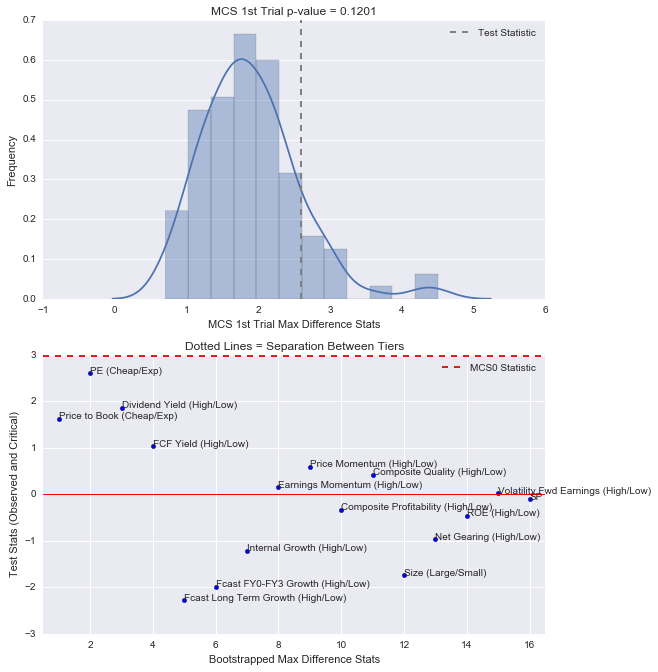

In [227]:
parameters = {"UpperType": "stationary", "UpperBlockSize": 5, "UpperSize": 100,
              "LowerType": "stationary", "LowerBlockSize": 5, "LowerSize": 30,
              "MCS_Step1BootType": "stationary", "MCS_Step1BootBlockSize": 5, "MCS_Step1BootSize": 500,
              "PerfMetric": "AvgReturn", "Vol-Scaling": 0.1, # AvgReturn, SharpeRatio, Vol
              "BetterOff": "Max", "Studentized": True, "SignificanceLevel": 0.05} 

os.chdir("X:\\Adriano\\python\\Factor Relevance")
df = pd.read_csv("factor_asset_returns_small.csv", index_col=0)
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")
df.ix[:, 0].plot() # check if index are shuffled
df = df["2001":"2007"].pct_change().fillna(0)

#rc_type = "Romano-Wolf"
#rc_results = rc_tests(df.ix[:, :-1], rc_type, benchmark=df.ix[:, -1], parameters=parameters)
#rc_analysis(rc_results, rc_type)
rc_results = rc_tests(df, "MCS", parameters=parameters)
rc_analysis(rc_results, rc_type)

#a = vanilla_returns(7, 1000)
#a.ix[:, 0] = a.ix[:, 0]-0.001
#a.ix[:, 4] = a.ix[:, 4]+0.01
#a.ix[:, 3] = a.ix[:, 3]+0.005
#parameters = {"UpperType": "stationary", "UpperBlockSize": 5, "UpperSize": 100,
#              "LowerType": "stationary", "LowerBlockSize": 5, "LowerSize": 30,
#              "MCS_Step1BootType": "stationary", "MCS_Step1BootBlockSize": 5, "MCS_Step1BootSize": 500,
#              "PerfMetric": "AvgReturn", "Vol-Scaling": 0.1, # AvgReturn, SharpeRatio, Vol
#              "BetterOff": "Max", "Studentized": True, "SignificanceLevel": 0.05} 

#white_brc(a.ix[:, 1:], a.ix[:, 0], parameters)
#romanowolf_brc(a.ix[:, 1:], a.ix[:, 0], parameters)
#mcs_brc(a, parameters)
#rc_type = "Romano-Wolf"
#rc_results = rc_tests(a.ix[:, 1:], rc_type, benchmark=a.ix[:, 0], parameters=parameters)
#rc_analysis(rc_results, rc_type)
#rc_type = "MCS"
#rc_results = rc_tests(a, rc_type, parameters=parameters)
#rc_analysis(rc_results, rc_type)

-> Look after styles:		
	--> Factors relevance a la Random Forest
		---> Factors Return
		---> Bootstrap
			----> Traditional
			----> Dependent
		---> Random Subspace
			----> Fraction
			----> Log and Sqrt
		---> Organize Portfolio
			----> MV
			----> Risk-Parity
			----> Equally-Weighted
		---> Compute Metrics (SR, Vol, MDD, etc.)
			----> In-sample
			----> Out-of-Bag
			----> Out-of-Sample
		---> Compute factors relevance for each metric
			----> Out-of-Bag * weight
			----> Permutation * weight
			----> Divergence (in-sample and out-of-Bag) *weight
		---> Show in a scatter plot (two metrics) or a barplot (one metric)
			----> Double Bootstrap
			----> Implement Breiman Cut-off